## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## Paths

In [2]:
TRAIN = '../Data/df_train.csv'
TEST = '../Data/df_test.csv'

## Functions

In [3]:
# code from exercise 5 to calculate the z-score
z_score = lambda x : (x - np.mean(x, axis=0)) / np.std(x, axis=0)

## from exercise 9 
def conf_mat(y_hat, y_true):
    '''Returns a confusion matrix'''
    n = max(y_hat)+1
    bingo = np.zeros([n,n])
    for i in range(len(y_hat)):
        bingo[y_true[i]][y_hat[i]] +=1
    
    return(bingo)

def scores(y_hat, y_true, average = False):
    '''For each class, returns recall, precision and f1'''
    y_true = y_true.cpu()
    classes = list(np.unique(y_true))
    conf = conf_mat(y_hat, y_true)
    r = []
    p = []
    f = []
    for c in classes:
        recall = conf[c][c] / sum(conf[c])
        precision = conf[c][c] / sum(conf[:, c])
        f1 = 2*(precision*recall)/(precision + recall)
        r.append(recall)
        p.append(precision)
        f.append(f1)
    if average:
        return sum(r)/len(r), sum(p)/len(p), sum(f)/len(f)
    else:
        return (r, p, f)

## Variables and df loading

In [4]:
col = 'rainbow' # Colour theme

df = pd.read_csv(TRAIN) # Training dataframe
#print(df.head(3))
df = df.sample(frac=1, random_state=42).reset_index(drop=True) #ensures data is without order.
#print(df.head(3))
attributes = list(df.columns)[:-1] # Creates list of column names for the dataframe without the class

X = df[attributes].copy() # Attributes
y = df['type'].copy() # True values

df['type_desc'] = ''
y_types = {0: 'ERROR', 1:'wind_float', 
           2:'wind_non', 3:'wind_veh',
           4: 'ERROR', 5:'container', 
           6:'tableware', 7:'headlamp'} # Matches catagory name to class number
y_list = y.unique() # 'y' values

for i in y_list: # This changes the 'type' to a descriptive word rather than a number
    # This is more human readable for plotting later - 'y' is still using the numbers
    df['type_desc'][df['type'] == i] = y_types[i]
    
df.head(3) #decision trees are not affected by scale so don't need to standardise the data

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type,type_desc
0,1.52664,11.23,0.00,0.77,73.21,0.00,14.68,0.0,0.00,2,wind_non
1,1.51627,13.00,3.58,1.54,72.83,0.61,8.04,0.0,0.00,2,wind_non
2,1.51796,13.50,3.36,1.63,71.94,0.57,8.81,0.0,0.09,3,wind_veh


In [5]:
def Gini(g_df, y,threshold):
    '''Function to calculate the Gini Impurity at the given split in the data
    for use in a Decision Tree Classifier.
    
    Input Parameters
    ----------
    
    g_df: A pandas dataframe with all rows of the data, in one specific column (attribute) only. 
    Does not include the class label.
    
    y: A pandas dataframe of all the class labels for each row.
    
    threshold: The given threshold to divide the data for use in calculating the impurity.
    
    Returns
    ----------
    gini: The Gini Impurity value used to decide if the given split is the optimal. Calculation is a linear combination
    of the weighted gini of the left node plus the weighted gini of the right node.
    
    node_gini: The impurity of the whole input data.
    
    class_count: a list of the number assigned to each class, 
    used to calc impurity and later for classification.
    
    '''
    
    g_df = pd.concat([g_df,y], axis=1,)
    g_df.columns=['Att', 'class']
    
    # Initialize an array of zeros to count number of each class in the whole node
    class_count = np.zeros((8), dtype=int)
    for i in range(len(g_df)):
        class_count[g_df['class'].iloc[i]]+=1

    
    # Proportion of each class present out of the total count
    proportion = [class_count[i]/np.sum(class_count) for i in range(len(class_count))]
    
    # Calculate the gini impurity for the entire node (is not used to calculate if the split is optimal)
    node_gini = 0
    for i in range(len(proportion)):
        node_gini += proportion[i]*(1-proportion[i])  
    
    # Split the data using the given attribute and threshold
    df_a = g_df[g_df['Att'] <= threshold]
    df_b = g_df[g_df['Att'] > threshold]
    
    n = g_df.shape[0] # Length of the whole node
    n_a = df_a.shape[0] # Length of side a
    n_b = df_b.shape[0] # Length of side b
    
    # Calculate and return gini impurity for each side
    gini_a = 0
    gini_b = 0
    for k in y_list: # loop through all classes
        
        k_a = df_a[df_a['class'] == k] 
        p_ka = len(k_a)/len(df_a) # Count of class k in split a, divided by total in that side.
        
        k_b = df_b[df_b['class'] == k]
        p_kb = len(k_b)/len(df_b) # Count of class k in split b, divided by total in that side.
                
        gini_a += (p_ka* (1-p_ka)) # Add p(1-p) of side a to the gini of side a
        gini_b += (p_kb* (1-p_kb)) # Add p(1-p) of side b to the gini of side b
        
    # Weighted gini impurity score that decides if the split is optimal    
    gini = (n_a/n)*gini_a + (n_b/n)*gini_b
    
    #print(round(gini_a, 3), round(gini_b, 3)) #The gini scores of each leaf
    
    return gini, node_gini, class_count # weighted gini from leaves != overall node gini
        
        
Gini(df['Ba'],y, 0.4) #0.736

(0.6199065196548418,
 0.7355524525922255,
 array([ 0, 49, 53, 12,  0,  9,  6, 20]))

In [6]:
def leaf_hunter(df, class_name = 'type'):
    '''Greedy function that calculates the optimal split in data at a node for a Decision Tree Classifier.
    
    Inputs
    ---------
        df : a dataframe with all attributes and rows, including class labels.
    
    Returns a dictionary with the following values:
    ---------
        best_gini : best weighted leaf gini scores (used to decide the optimal split)
        best_threshold : best threshold to split the data
        best_att : best attribute (used to decide how to split the data)
        node_gini : node gini score
        class_count : class counts for the imput node that is being split
    '''
    
    # Initialize variables
    best_gini = 1
    best_class = ''
    best_threshold = 0
    best_att = 0
    class_cnt = 0
    node_gini = 0
    
    # If there is only 1 row in the data, the node cannot be split
    if df.shape[0] == 1:
        class_count = np.zeros((8), dtype=int)
        for i in df[class_name]:
            class_count[i] += 1
        return {'best_gini': 0, 
                'best_threshold': 0, 
                'best_att': 0, 
                'node_gini': 0,
                'class_count': class_count}
    
    for a in attributes: # Loop through attributes
        tmp = df.sort_values(by=a, axis=0).copy()
        
        for threshold in range(len(df)-1): # Loop through potential thresholds, which are points halfway between each data point
            
            if tmp[a].iloc[threshold] != tmp[a].iloc[threshold+1]: # Skip if the two points are the same value
                thresh = (tmp[a].iloc[threshold] + tmp[a].iloc[threshold+1])/2
                #print((tmp[a].iloc[threshold], tmp[a].iloc[threshold+1]), thresh)
                
                # Calculate the gini impurity at that split
                gini, node_gini, class_count = Gini(df[a], df[class_name], thresh)
                
                # If the gini impurity is lower, overwrite the variables to the current settings
                if gini < best_gini:
                    best_gini = gini
                    best_threshold = thresh
                    best_att = a
                    class_cnt = class_count
                
    return {'best_gini': best_gini, 
            'best_threshold': best_threshold, 
            'best_att': best_att, 
            'node_gini': node_gini,
            'class_count': class_count}

leaf = leaf_hunter(df)

print(leaf)

{'best_gini': 0.6199065196548418, 'best_threshold': 0.4, 'best_att': 'Ba', 'node_gini': 0.7355524525922255, 'class_count': array([ 0, 49, 53, 12,  0,  9,  6, 20])}


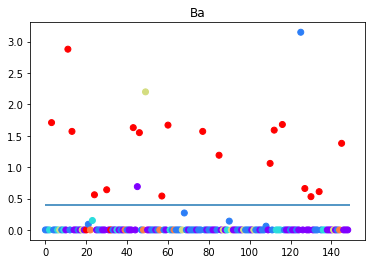

In [7]:
# Visualize the first split in the data
plt.scatter([i for i in range(len(df))], df[leaf["best_att"]], c=y, cmap=col)
plt.hlines(leaf["best_threshold"], 0, 149)
plt.title(f"{leaf['best_att']}");
#plt.savefig('../Vis/split 1');

In [8]:
# Initialize a sklearn Decision Tree Classifier to compare results
clf = DecisionTreeClassifier(max_depth=5)
model = clf.fit(X, y)

In [9]:
sum(model.predict(X)==y)/(len(y)/100)# Check accuracy of the decision tree at this level

81.20805369127517

[(0, 'RI'), (1, 'Na'), (2, 'Mg'), (3, 'Al'), (4, 'Si'), (5, 'K'), (6, 'Ca'), (7, 'Ba'), (8, 'Fe')]


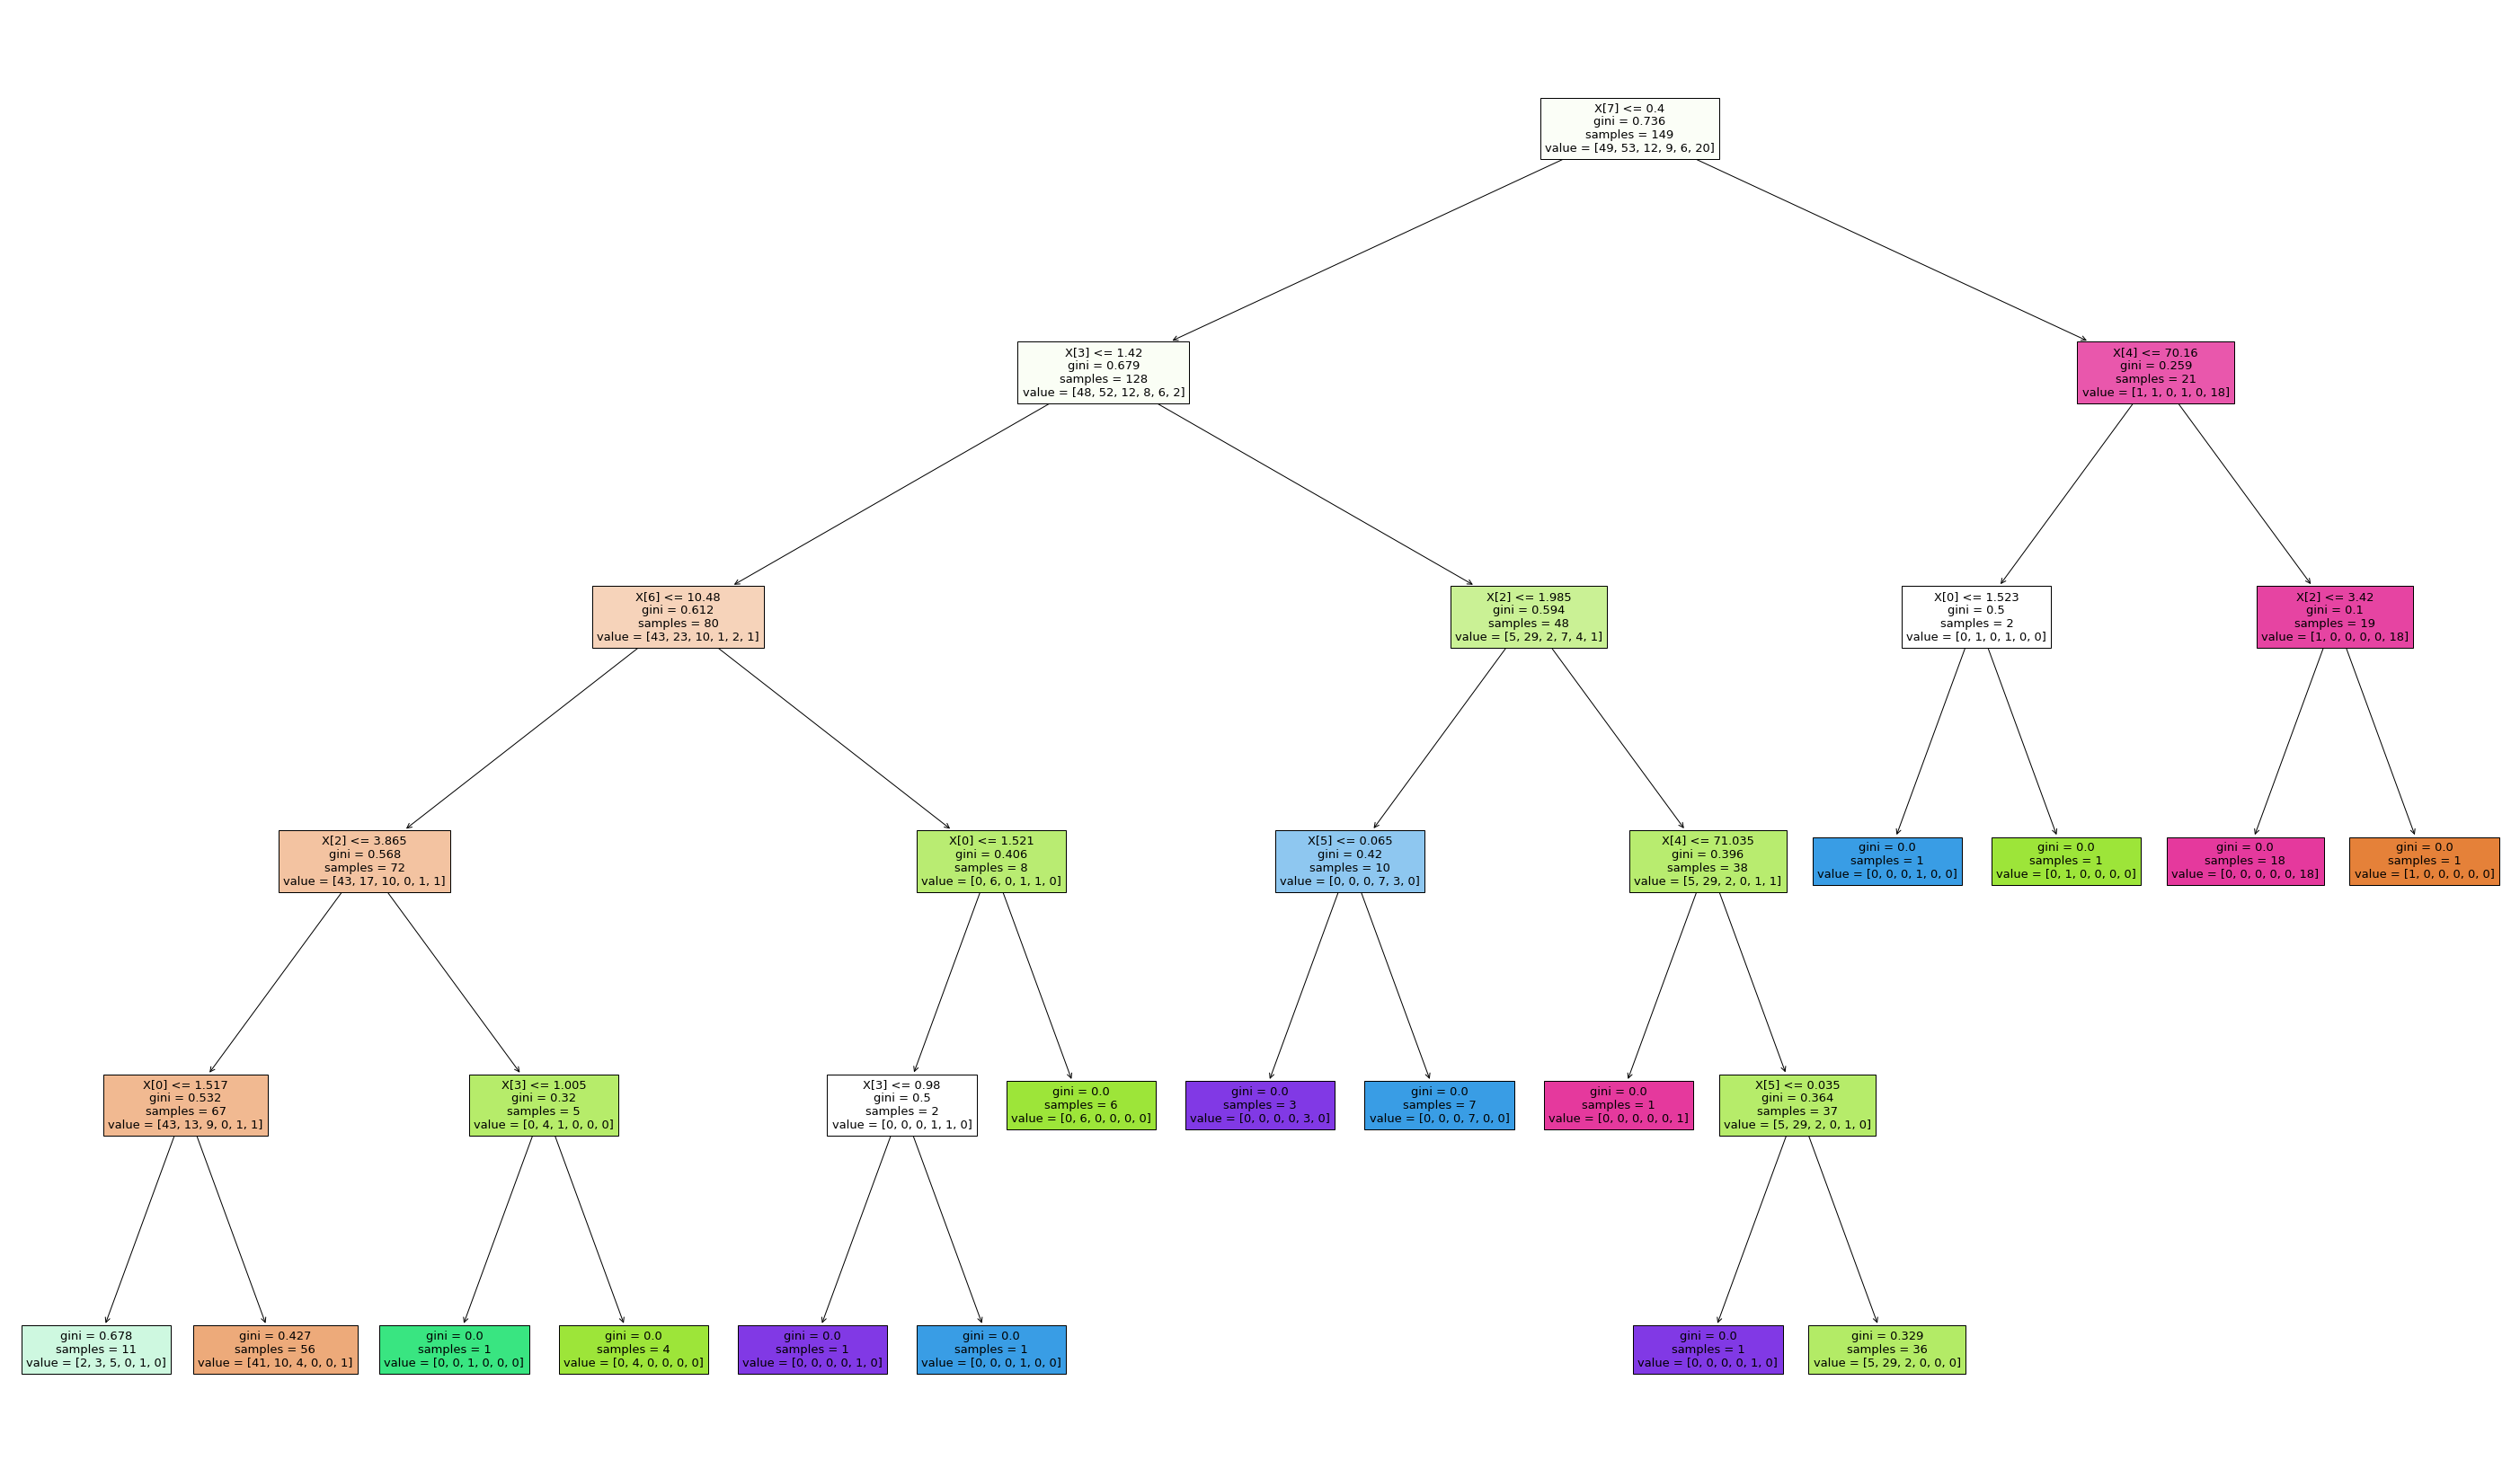

In [10]:
fig = plt.figure(figsize=(50,30))
_ = tree.plot_tree(model, filled=True)
print([(i, attributes[i]) for i in range(len(attributes))]);
#plt.savefig('../Vis/sklearn_tree');

In [11]:
#plt.scatter([i for i in range(149)], df['Ba'], c=y, cmap=col)
#plt.hlines(0.4, 0, 149)
#plt.title('Ba');

128 21
{'best_gini': 0.6050781249999999, 'best_threshold': 1.42, 'best_att': 'Al', 'node_gini': 0.67919921875, 'class_count': array([ 0, 48, 52, 12,  0,  8,  6,  2])}


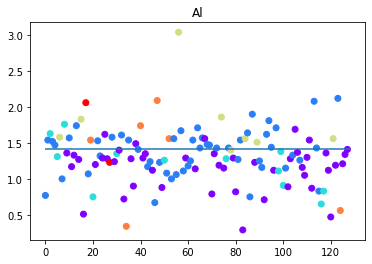

In [12]:
# Visualize one of the second splits
a_df = df[df[leaf['best_att']] <= leaf["best_threshold"]].copy()
b_df = df[df[leaf['best_att']] > leaf["best_threshold"]].copy()
print(a_df.shape[0], b_df.shape[0])

leaf_a  = leaf_hunter(a_df)

print(leaf_a)

plt.scatter([i for i in range(a_df.shape[0])], a_df[leaf_a['best_att']], c=a_df['type'], cmap=col)
plt.hlines(leaf_a["best_threshold"], 0, a_df.shape[0])
plt.title(f'{leaf_a["best_att"]}');
#plt.savefig('../Vis/a_split');

{'best_gini': 0.1378446115288221, 'best_threshold': 70.16, 'best_att': 'Si', 'node_gini': 0.2585034013605442, 'class_count': array([ 0,  1,  1,  0,  0,  1,  0, 18])}


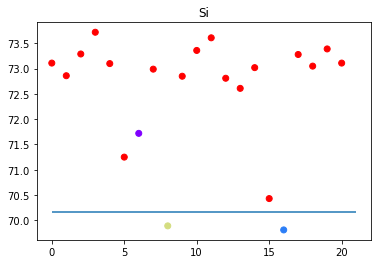

In [13]:
# Visualize the other second split
leaf_b  = leaf_hunter(b_df)

print(leaf_b)

plt.scatter([i for i in range(b_df.shape[0])], b_df[leaf_b['best_att']], c=b_df['type'], cmap=col)
plt.hlines(leaf_b["best_threshold"], 0, b_df.shape[0])
plt.title(f'{leaf_b["best_att"]}');
#plt.savefig('../Vis/b_split');

In [14]:
class DecisionTree:
    '''A Decision Tree Classifier. Initializes a node based on the input dataframe. Then splits the node using
    the leaf_hunter funtion. Each split is initialized as a new node, which is recursively split until there is 
    only 1 class left in the node, or the intitialized max depth is reached.
    '''
    
    def __init__(self, df, class_name_ = 'type', max_depth=20, print_nodes=False, depth=0, tree_text = False):     
        ''' 
        Parameters:
        -----------
        df : Complete dataframe, including class labels
        max_depth : Depth of the tree, Default=20
        print_nodes : Bool that triggers whether or not to print the nodes of the tree, default=False
        depth : Initial depth of the tree, default=0
        tree_text : Bool that triggers whether the tree should be output to a text file. Default=False
        '''
        
        # Use leaf_hunter function to find the optimal split in the data, and set the variables accordingly
        tmp = leaf_hunter(df, class_name_)
        self.depth = depth
        self.node_gini = tmp['node_gini']
        self.best_gini = tmp['best_gini']
        self.best_att = tmp['best_att']
        self.best_threshold = tmp['best_threshold']
        self.class_count = tmp['class_count']
        self.no_classes = len(np.nonzero(self.class_count)[0])
        self.max_depth = max_depth
        self.classification = int(np.where(self.class_count == np.amax(self.class_count))[0][0]) 
        
        # If there is only 1 class present in the node, it cannot be further split
        if self.no_classes == 1 or self.max_depth < 1:
            self.has_children = False
        else:
            self.has_children = True
        
        # If parameter print_nodes=True, print the node
        if print_nodes:
            print(self)
        
        if tree_text:
            # If node depth==0, start a new document and write node to it
            if self.depth==0:
                with open('../Report/tree.txt', 'w') as f:
                    f.write(f'{str(self)}')
            # Else, append new node to the document
            else:
                with open('../Report/tree.txt', 'a') as f:
                    f.write(f'{str(self)}')
                
        if self.has_children:
            a = df[df[self.best_att] <= self.best_threshold]
            b = df[df[self.best_att] > self.best_threshold]
            self.child_a = DecisionTree(a, class_name_, self.max_depth-1, print_nodes, self.depth+1, tree_text)
            self.child_b = DecisionTree(b, class_name_, self.max_depth-1, print_nodes, self.depth+1, tree_text)
            
    def __str__ (self):
        '''__str__ method for the class, used for printing the node attributes.
        '''
        
        peanut = {attributes[i]: i for i in range(len(attributes))}
        peanut[0] = ''
        
        return(f'Depth: {self.depth}'
              + f'\n{"  "*self.depth}Node Gini: {self.node_gini}'
              + f'\n{"  "*self.depth}Attribute: {self.best_att} ({peanut[self.best_att]})'
              + f'\n{"  "*self.depth}Threshold: {self.best_threshold}'
              + f'\n{"  "*self.depth}Classes: {self.class_count}'
              + f'\n{"  "*self.depth}No classes: {self.no_classes}'
              + f'\n{"  "*self.depth}Node classification: {self.classification}'
              + f'\n{"  "*self.depth}Has children: {self.has_children}'
              + f'\n{"  "*self.depth}-----------------------\n')
        
    def predict(self, test, force_depth=100):
        '''Predict method.
        Parameters
        ----------
            test : 
            force_depth : 
        Returns
        ----------
            classes: the 
        '''
        classes = []
        for i in range(len(test)):
            t = test.iloc[i]
            searching = True
            sam = self # Makes sam a copy of the decision tree
            
            '''for datapoint in the test list, follows the tree down until in ends in a leaf node,
            or reaches a set depth and then takes its classification from the node it ends in
            - this means we don't have to retrain the model when looking for the optimum depth.'''
            while searching:
                if sam.has_children and sam.depth < force_depth:  
                    if t[sam.best_att] <= sam.best_threshold:
                        sam = sam.child_a
                    else:
                        sam = sam.child_b
                else:
                    searching = False
                
            classes.append(sam.classification)
        return classes
        
bob = DecisionTree(df, tree_text=True)#, print_nodes=True) # This fits the model to the data equiv to .fit()

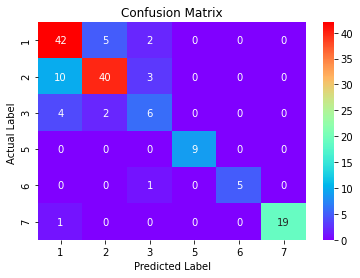

In [15]:
test_ind = [i for i in range(len(df))]#[79, 117, 137]
test = X.iloc[test_ind]
bob_pred = bob.predict(test, force_depth= 5)

cf = confusion_matrix(df['type'], bob_pred)

ax = sns.heatmap(cf, annot=True, cmap=col, xticklabels=[1,2,3,5,6,7], yticklabels=[1,2,3,5,6,7])

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label ');

In [16]:
banana = 0 # keeps track of correct classifications
df_trained = df.copy()
df_trained['classification'] = ''

for i in range(len(df)):
    test = df.iloc[i]
    searching = True
    sam = bob # makes sam, a copy of the decision tree
    while searching:
        if sam.has_children and sam.depth < 5: # change depth here for overtraining stuff
            if test[sam.best_att] <= sam.best_threshold:
                sam = sam.child_a
            else:
                sam = sam.child_b
        else:
            searching = False
    df_trained['classification'].iloc[i] = sam.classification
    if sam.classification == test['type']:
        banana +=1
    else:
        pass
        #print('wrong', i, test['type_desc'], sam.classification)
        
print(f'{round(banana/1.49, 2)}% correct') #should be 100% whilst we are overtraining the model

81.21% correct


In [17]:
df_trained[df_trained['type'] != df_trained['classification']]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type,type_desc,classification
2,1.51796,13.50,3.36,1.63,71.94,0.57,8.81,0.00,0.09,3,wind_veh,2
9,1.51665,13.14,3.45,1.76,72.48,0.60,8.38,0.00,0.17,3,wind_veh,2
21,1.51851,13.20,3.63,1.07,72.83,0.57,8.41,0.09,0.17,2,wind_non,1
23,1.51934,13.64,3.54,0.75,72.65,0.16,8.89,0.15,0.24,3,wind_veh,1
27,1.51844,13.25,3.76,1.32,72.40,0.58,8.42,0.00,0.00,2,wind_non,1
29,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.00,0.26,1,wind_float,2
32,1.52315,13.44,3.34,1.23,72.38,0.60,8.83,0.00,0.00,7,headlamp,1
36,1.51589,12.88,3.43,1.40,73.28,0.69,8.05,0.00,0.24,1,wind_float,3
39,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.00,0.00,6,tableware,3
44,1.51750,12.82,3.55,1.49,72.75,0.54,8.52,0.00,0.19,1,wind_float,2


4 13.33%
6 20.0%
4 13.33%
12 40.0%
5 17.24%
31 149 20.81%


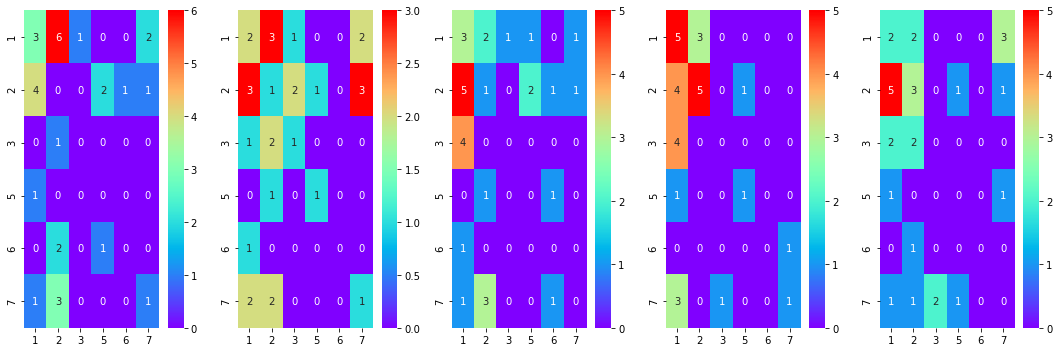

In [18]:
splits = 5 #control number of splits
fig, axes = plt.subplots(1,splits, figsize=(15,5))
axes.flatten()
fig.tight_layout()

from sklearn.model_selection import KFold

mini = df #this was so I could run smaller tests easily ie df[0:10] for speed

kf = KFold(n_splits=splits) #create the size of the splits

results = {} #holds the predictions for each fold
c = 0 # controls the count through the results

for train, test in kf.split(mini[attributes]):
    #print(f"{len(train)}, {len(test)}")
    luci = DecisionTree(pd.DataFrame(mini.iloc[train]), max_depth=5) #train a DT for current fold
    pred = luci.predict(pd.DataFrame(mini[attributes].iloc[test])) #predict for current fold
    results[c] = [j for j in zip(train,pred)] #store index and prediction
    c+=1
    #print(train)

#I went for a fruit theme here... We should probably change this
banana = 0 #holds count of correct predictions

for l in range(splits):
    apple = 0 #holds count of correct predictions for current fold
    

        
    cf = confusion_matrix(mini['type'].iloc[[k for k,v in results[l]]], [v for k,v in results[l]])
    sns.heatmap(cf, annot=True, cmap=col, xticklabels=[1,2,3,5,6,7], yticklabels=[1,2,3,5,6,7], ax = axes[l])

        
    for k,v in results[l]:
        if v == df['type'].iloc[k]: #if prediction is true:        
        
        
            apple+=1
    print(apple, f'{round(100*apple/len(results[l]), 2)}%') #prints % correct for current fold
    banana += apple
    
print(banana, len(mini), f'{round(100*banana/len(mini), 2)}%') #prints overall correct predictions.

16 53.33%
15 50.0%
14 46.67%
16 53.33%
13 44.83%
74 149 49.66%


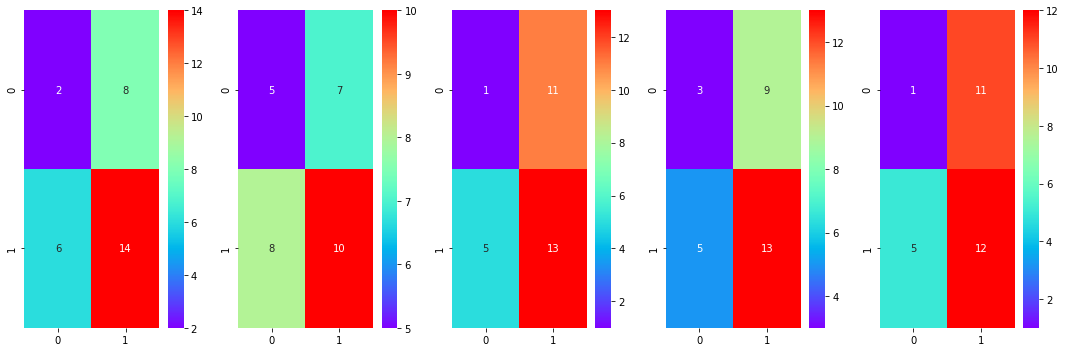

In [19]:
# Just to see how well it does at predicting the 2 window vs non-window glass only.

df['short_type'] = 0

df['short_type'][df['type'] == 1] = 1
df['short_type'][df['type'] == 2] = 1


#print(f"Type 0: {df[df['short_type'] == 0].shape[0]}\nType 1: {df[df['short_type'] == 1].shape[0]}")

splits = 5 #control number of splits
fig, axes = plt.subplots(1,splits, figsize=(15,5))
axes.flatten()
fig.tight_layout()

from sklearn.model_selection import KFold

mini = df #this was so I could run smaller tests easily ie df[0:10] for speed

kf = KFold(n_splits=splits) #create the size of the splits

results = {} #holds the predictions for each fold
c = 0 # controls the count through the results

for train, test in kf.split(mini[attributes]):
    #print(f"{len(train)}, {len(test)}")
    luci = DecisionTree(pd.DataFrame(mini.iloc[train]), max_depth=5, class_name_= 'short_type') #train a DT for current fold
    pred = luci.predict(pd.DataFrame(mini[attributes].iloc[test])) #predict for current fold
    results[c] = [j for j in zip(train,pred)] #store index and prediction
    c+=1
    #print(train)

#I went for a fruit theme here... We should probably change this
banana = 0 #holds count of correct predictions

for l in range(splits):
    apple = 0 #holds count of correct predictions for current fold
    

        
    cf = confusion_matrix(mini['short_type'].iloc[[k for k,v in results[l]]], [v for k,v in results[l]])
    sns.heatmap(cf, annot=True, cmap=col, xticklabels=[0,1], yticklabels=[0,1], ax = axes[l])

        
    for k,v in results[l]:
        if v == df['short_type'].iloc[k]: #if prediction is true:        
        
        
            apple+=1
    print(apple, f'{round(100*apple/len(results[l]), 2)}%') #prints % correct for current fold
    banana += apple
    
print(banana, len(mini), f'{round(100*banana/len(mini), 2)}%') #prints overall correct predictions.

In [20]:
df[df['short_type']== 0].shape[0], df[df['short_type']== 1].shape[0]

(47, 102)

In [21]:
kate = DecisionTree(df, class_name_='short_type')

90.6% correct


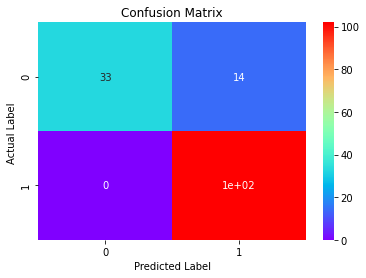

In [22]:
banana = 0 # keeps track of correct classifications
tree_depth = 3

df_trained = df.copy()
df_trained['classification'] = ''

for i in range(len(df)):
    test = df.iloc[i]
    searching = True
    sam = kate # makes sam, a copy of the decision tree
    while searching:
        if sam.has_children and sam.depth < tree_depth: # change depth here for overtraining stuff
            if test[sam.best_att] <= sam.best_threshold:
                sam = sam.child_a
            else:
                sam = sam.child_b
        else:
            searching = False
    df_trained['classification'].iloc[i] = sam.classification
    if sam.classification == test['short_type']:
        banana +=1
    else:
        pass
        #print('wrong', i, test['type_desc'], sam.classification)
        
print(f'{round(banana/1.49, 2)}% correct') #should be 100% whilst we are overtraining the model

test_ind = [i for i in range(len(df))]
test = X.iloc[test_ind]
kate_pred = kate.predict(test, force_depth= tree_depth)

cf = confusion_matrix(df['short_type'], kate_pred)

ax = sns.heatmap(cf, annot=True, cmap=col, xticklabels=[0,1], yticklabels=[0,1])

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label ');

In [23]:
df_trained[df['short_type'] != kate_pred]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type,type_desc,short_type,classification
2,1.51796,13.50,3.36,1.63,71.94,0.57,8.81,0.00,0.09,3,wind_veh,0,1
6,1.51694,12.86,3.58,1.31,72.61,0.61,8.79,0.00,0.00,3,wind_veh,0,1
9,1.51665,13.14,3.45,1.76,72.48,0.60,8.38,0.00,0.17,3,wind_veh,0,1
32,1.52315,13.44,3.34,1.23,72.38,0.60,8.83,0.00,0.00,7,headlamp,0,1
35,1.51643,12.16,3.52,1.35,72.89,0.57,8.53,0.00,0.00,3,wind_veh,0,1
61,1.51646,13.04,3.40,1.26,73.01,0.52,8.58,0.00,0.00,3,wind_veh,0,1
89,1.51655,13.41,3.39,1.28,72.64,0.52,8.65,0.00,0.00,3,wind_veh,0,1
102,1.52119,12.97,0.33,1.51,73.39,0.13,11.27,0.00,0.28,5,container,0,1
112,1.51719,14.75,0.00,2.00,73.02,0.00,8.53,1.59,0.08,7,headlamp,0,1
113,1.51769,13.65,3.66,1.11,72.77,0.11,8.60,0.00,0.00,3,wind_veh,0,1


In [24]:
#loads and predicts on the TEST data, run this last once everything else is in place then don't change stuffs
#df_test = pd.read_csv(TEST) #training dataframe

#X_test = df_test[attributes].copy() #attributes
#df_test[attributes] = df_test[attributes]
#y_test = df_test['type'].copy() #true values

#sum([i==j for i,j in zip(bob.predict(X_test), y_test)]), len(X)